In [54]:
import numpy as np
import pickle as pkl
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay 


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

tf.__version__

'2.8.2'

In [55]:
! nvidia-smi

Tue Jun  7 14:38:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |    444MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Model Build with raw data extract - Feature dimesion == 40  

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
XDATA_PATH = '/content/drive/MyDrive/UrbanSound8K/Xvalues'
YDATA_PATH = '/content/drive/MyDrive/UrbanSound8K/yvalues'

with open(XDATA_PATH, 'rb') as f:
  X = pkl.load(f)
with open(YDATA_PATH, 'rb') as f:
  y = pkl.load(f)

X.shape, y.shape, X.dtype

((8732, 40), (8732,), dtype('float32'))

In [58]:
# encode y labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
mappings = {index: label for index, label in enumerate(le.classes_)}
print('encoded data mapping')
print(mappings)
print('\n \n')

print('one hot encoded')
y_encoded = to_categorical(y_encoded)
y_encoded, y_encoded.shape

encoded data mapping
{0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}

 

one hot encoded


(array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), (8732, 10))

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y_encoded, test_size=0.2,
                                                    random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1,
                                                  random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6286, 40), (1747, 40), (6286, 10), (1747, 10))

In [60]:
# Build Artificial Neural Network 

# set seed
tf.random.set_seed(42)

X_INPUT_SHAPE = 40
Y_INPUT_SHAPE = 10

# create ANN architecture
model1 = tf.keras.Sequential([
          
          #first layer + Dropout
          tf.keras.layers.Dense(100, input_shape=(X_INPUT_SHAPE,), activation='relu', name='First_layer'),
          tf.keras.layers.Dropout(0.2),

          # second layer + Dropout
          tf.keras.layers.Dense(200, activation='relu', name='second_layer'),
          tf.keras.layers.Dropout(0.2),

          # Third layer + Dropout
          tf.keras.layers.Dense(100, activation='relu', name='third_layer'),
          tf.keras.layers.Dropout(0.2),

          # fourth layer
          tf.keras.layers.Dense(100, activation='relu', name='fourth_layer'),
          tf.keras.layers.Dropout(0.2),

          # output layer - one hot y_values
          tf.keras.layers.Dense(Y_INPUT_SHAPE, activation='softmax', name='output_layer')
])

# compile model
model1.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# lr scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * (10**(epoch/20)))

In [61]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_layer (Dense)         (None, 100)               4100      
                                                                 
 dropout_21 (Dropout)        (None, 100)               0         
                                                                 
 second_layer (Dense)        (None, 200)               20200     
                                                                 
 dropout_22 (Dropout)        (None, 200)               0         
                                                                 
 third_layer (Dense)         (None, 100)               20100     
                                                                 
 dropout_23 (Dropout)        (None, 100)               0         
                                                                 
 fourth_layer (Dense)        (None, 100)              

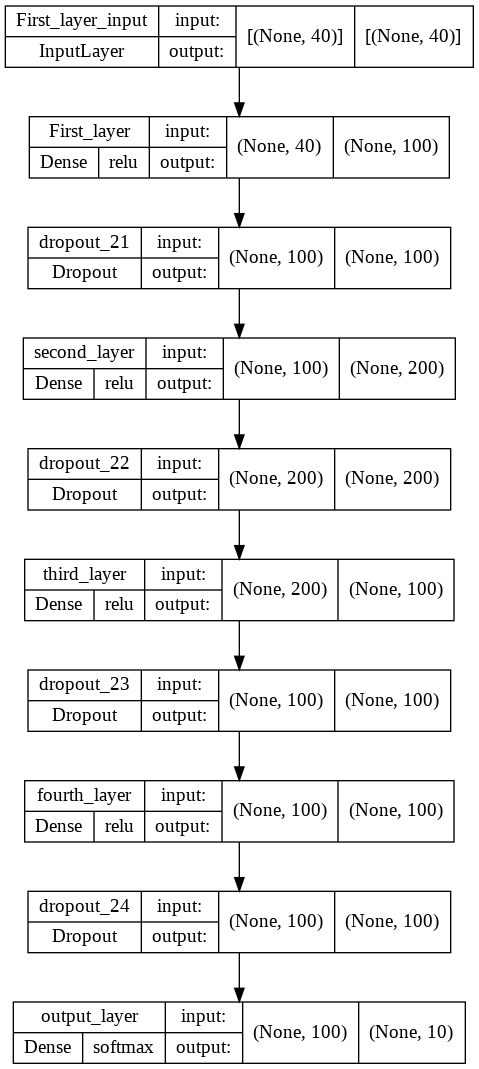

In [62]:
plot_model(model=model1, show_shapes=True, show_layer_activations=True)

In [63]:
history1 = model1.fit(X_train, y_train, epochs=100,
                      validation_data=(X_val,y_val),
                      callbacks=[lr_scheduler],verbose=1)

Epoch 1/100
197/197 [==============================] - 2s 8ms/step - loss: 9.9271 - accuracy: 0.1131 - val_loss: 2.3476 - val_accuracy: 0.1674 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 1s 6ms/step - loss: 4.1236 - accuracy: 0.1319 - val_loss: 2.1985 - val_accuracy: 0.1888 - lr: 1.1220e-04
Epoch 3/100
197/197 [==============================] - 1s 6ms/step - loss: 2.9003 - accuracy: 0.1470 - val_loss: 2.2350 - val_accuracy: 0.1702 - lr: 1.2589e-04
Epoch 4/100
197/197 [==============================] - 1s 6ms/step - loss: 2.5087 - accuracy: 0.1470 - val_loss: 2.2344 - val_accuracy: 0.1917 - lr: 1.4125e-04
Epoch 5/100
197/197 [==============================] - 1s 6ms/step - loss: 2.3388 - accuracy: 0.1678 - val_loss: 2.2091 - val_accuracy: 0.1917 - lr: 1.5849e-04
Epoch 6/100
197/197 [==============================] - 1s 6ms/step - loss: 2.2521 - accuracy: 0.1814 - val_loss: 2.1716 - val_accuracy: 0.1931 - lr: 1.7783e-04
Epoch 7/100
197/197 [===================

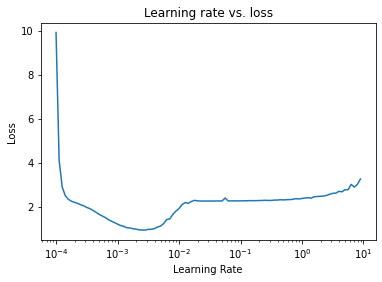

In [64]:
epoch = 100
lr = 1e-4 * (10**(np.arange(epoch)/20))
# plt.figure(figsize=(20,5))
plt.semilogx(lr, history1.history['loss'])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");
plt.show()

In [65]:
1# set seed
tf.random.set_seed(42)

X_INPUT_SHAPE = 40
Y_INPUT_SHAPE = 10

# create ANN architecture
model2 = tf.keras.Sequential([
          
          #first layer + Dropout
          tf.keras.layers.Dense(100, input_shape=(X_INPUT_SHAPE,), activation='relu', name='First_layer'),
          tf.keras.layers.Dropout(0.2),

          # second layer + Dropout
          tf.keras.layers.Dense(200, activation='relu', name='second_layer'),
          tf.keras.layers.Dropout(0.2),

          # Third layer + Dropout
          tf.keras.layers.Dense(200, activation='relu', name='third_layer'),
          tf.keras.layers.Dropout(0.2),

          # fourth layer
          tf.keras.layers.Dense(100, activation='relu', name='fourth_layer'),
          tf.keras.layers.Dropout(0.2),

          # output layer - one hot y_values
          tf.keras.layers.Dense(Y_INPUT_SHAPE, activation='softmax', name='output_layer')
])

# compile model
model2.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)


history2 = model2.fit(X_train, y_train, epochs=50,
                      validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/50
197/197 [==============================] - 1s 4ms/step - loss: 3.4745 - accuracy: 0.1810 - val_loss: 2.0444 - val_accuracy: 0.2461
Epoch 2/50
197/197 [==============================] - 1s 3ms/step - loss: 2.0221 - accuracy: 0.2738 - val_loss: 1.7303 - val_accuracy: 0.3991
Epoch 3/50
197/197 [==============================] - 1s 3ms/step - loss: 1.7874 - accuracy: 0.3589 - val_loss: 1.5428 - val_accuracy: 0.4621
Epoch 4/50
197/197 [==============================] - 1s 3ms/step - loss: 1.6109 - accuracy: 0.4314 - val_loss: 1.3874 - val_accuracy: 0.5422
Epoch 5/50
197/197 [==============================] - 1s 3ms/step - loss: 1.4847 - accuracy: 0.4835 - val_loss: 1.2329 - val_accuracy: 0.5851
Epoch 6/50
197/197 [==============================] - 1s 3ms/step - loss: 1.3467 - accuracy: 0.5401 - val_loss: 1.1885 - val_accuracy: 0.6195
Epoch 7/50
197/197 [==============================] - 1s 3ms/step - loss: 1.2638 - accuracy: 0.5795 - val_loss: 1.0647 - val_accuracy: 0.6509
Epoch 

In [66]:
model2.evaluate(X_test, y_test)

55/55 [==============================] - 0s 2ms/step - loss: 0.3894 - accuracy: 0.8809


[0.3893953561782837, 0.8809387683868408]

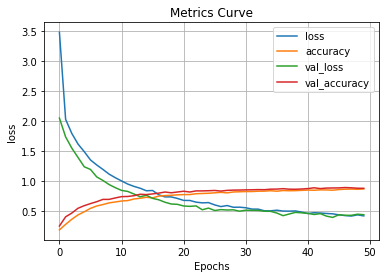

In [67]:
# metrics curve 
pd.DataFrame(history2.history).plot()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid(True)
plt.title('Metrics Curve')
plt.legend()
plt.show()

<Figure size 720x720 with 0 Axes>

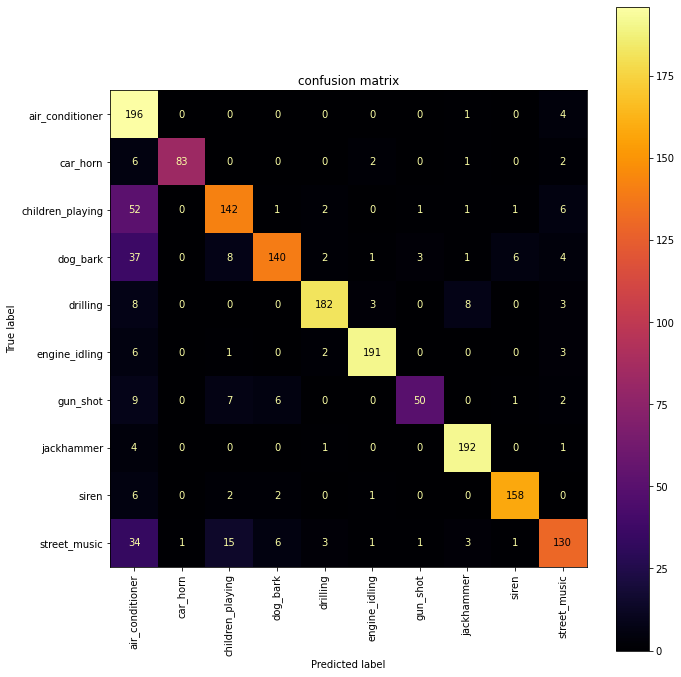

In [68]:
# confusion metrics

# make prediction
y_pred = tf.round(model2.predict(X_test))


# create confusion metrics
metric = cm(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))

labels = ['air_conditioner','car_horn','children_playing','dog_bark',
          'drilling','engine_idling','gun_shot','jackhammer','siren',
          'street_music']

plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(metric, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='inferno')
plt.title('confusion matrix')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [69]:
model2.save('raw_extract_model.h5')

### Model Build with raw extract statistics

In [70]:
# Train for dataset on stats values
data = pd.read_csv('https://raw.githubusercontent.com/Bee0933/UrbanSound8k/dev-branch/csv/extracted-MFCC-features.csv')
df = data.copy()
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,min_value,max_value,std,mean,median,skew,kurtosis,labels
0,-121.55058,65.455340,24.580328,-2.251908,-0.704169,-2.281909,12.540225,car_horn
1,-126.84716,115.877540,31.312760,-0.769311,0.445877,-0.430298,8.797351,car_horn
2,-252.96980,167.191250,48.798847,-2.647705,0.021331,-2.326509,17.988012,car_horn
3,-132.81130,55.071160,26.491137,1.429906,2.026098,-2.966784,14.084645,car_horn
4,-264.63226,40.243603,45.578290,-8.555743,-3.226343,-4.335254,22.043105,car_horn


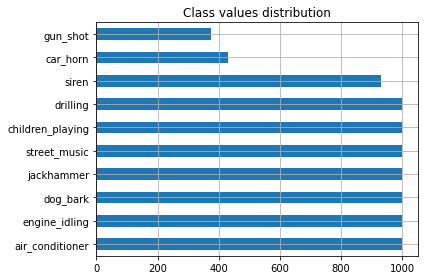

In [71]:
df['labels'].value_counts().plot(kind='barh'); plt.grid(True); plt.title('Class values distribution'); plt.tight_layout()

In [72]:
X_val = df.drop('labels', axis=1)
y_val = df.labels 
X_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   min_value  8732 non-null   float64
 1   max_value  8732 non-null   float64
 2   std        8732 non-null   float64
 3   mean       8732 non-null   float64
 4   median     8732 non-null   float64
 5   skew       8732 non-null   float64
 6   kurtosis   8732 non-null   float64
dtypes: float64(7)
memory usage: 477.7 KB


In [73]:
# encode y labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_val)
mappings = {index: label for index, label in enumerate(le.classes_)}
print('encoded data mapping')
print(mappings)
print('\n \n')

print('one hot encoded')
y_encoded = to_categorical(y_encoded)
y_encoded, y_encoded.shape

encoded data mapping
{0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}

 

one hot encoded


(array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), (8732, 10))

In [74]:
# scale X data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_val)

In [75]:
X_scaled, X_scaled.dtype

(array([[0.85717715, 0.22204604, 0.13115208, ..., 0.52179813, 0.342779  ,
         0.34442291],
        [0.85014715, 0.40781745, 0.19013373, ..., 0.57110809, 0.51017155,
         0.23486659],
        [0.68274807, 0.59687347, 0.34332627, ..., 0.55290502, 0.33874704,
         0.50388315],
        ...,
        [0.93324044, 0.14256563, 0.0542996 , ..., 0.48160861, 0.47357315,
         0.14068341],
        [0.78106723, 0.54843449, 0.2525794 , ..., 0.44166785, 0.47810166,
         0.41861239],
        [0.81287305, 0.37259353, 0.19555347, ..., 0.55139501, 0.38966664,
         0.37657851]]), dtype('float64'))

In [76]:
X_scaled.shape, y_encoded.shape

((8732, 7), (8732, 10))

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_encoded, test_size=0.2,
                                                    random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1,
                                                  random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6286, 7), (1747, 7), (6286, 10), (1747, 10))

In [78]:
# Build Artificial Neural Network 

# set seed
tf.random.set_seed(42)

X_INPUT_SHAPE = 7
Y_INPUT_SHAPE = 10

# create ANN architecture
model3 = tf.keras.Sequential([
          
          #first layer + Dropout
          tf.keras.layers.Dense(100, input_shape=(X_INPUT_SHAPE,), activation='relu', name='First_layer'),
          tf.keras.layers.Dropout(0.2),

          # second layer + Dropout
          tf.keras.layers.Dense(200, activation='relu', name='second_layer'),
          tf.keras.layers.Dropout(0.2),

          # Third layer + Dropout
          tf.keras.layers.Dense(200, activation='relu', name='third_layer'),
          tf.keras.layers.Dropout(0.2),

          # fourth layer
          tf.keras.layers.Dense(100, activation='relu', name='fourth_layer'),
          tf.keras.layers.Dropout(0.2),

          # output layer - one hot y_values
          tf.keras.layers.Dense(Y_INPUT_SHAPE, activation='softmax', name='output_layer')
])

# compile model
model3.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# lr scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * (10**(epoch/20)))

In [79]:
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_layer (Dense)         (None, 100)               800       
                                                                 
 dropout_29 (Dropout)        (None, 100)               0         
                                                                 
 second_layer (Dense)        (None, 200)               20200     
                                                                 
 dropout_30 (Dropout)        (None, 200)               0         
                                                                 
 third_layer (Dense)         (None, 200)               40200     
                                                                 
 dropout_31 (Dropout)        (None, 200)               0         
                                                                 
 fourth_layer (Dense)        (None, 100)              

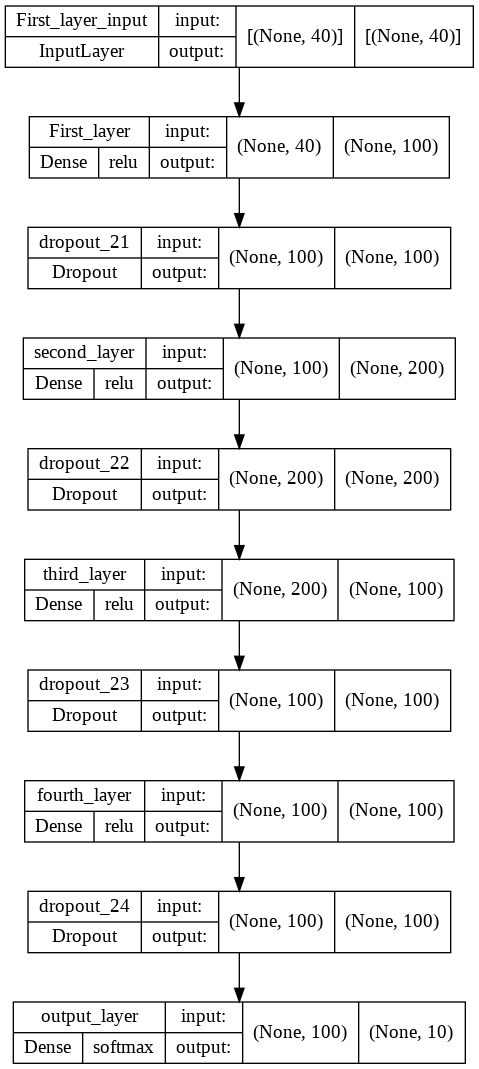

In [80]:
plot_model(model=model1, show_shapes=True, show_layer_activations=True)

In [81]:
history3 = model3.fit(X_train, y_train, epochs=100,
                      validation_data=(X_val,y_val),
                      callbacks=[lr_scheduler],verbose=1)

Epoch 1/100
197/197 [==============================] - 1s 4ms/step - loss: 2.2778 - accuracy: 0.1252 - val_loss: 2.2346 - val_accuracy: 0.2074 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 1s 3ms/step - loss: 2.1966 - accuracy: 0.1928 - val_loss: 2.1164 - val_accuracy: 0.1989 - lr: 1.1220e-04
Epoch 3/100
197/197 [==============================] - 1s 3ms/step - loss: 2.0955 - accuracy: 0.2151 - val_loss: 2.0251 - val_accuracy: 0.2160 - lr: 1.2589e-04
Epoch 4/100
197/197 [==============================] - 1s 3ms/step - loss: 2.0391 - accuracy: 0.2321 - val_loss: 1.9926 - val_accuracy: 0.2303 - lr: 1.4125e-04
Epoch 5/100
197/197 [==============================] - 1s 3ms/step - loss: 2.0069 - accuracy: 0.2458 - val_loss: 1.9396 - val_accuracy: 0.2904 - lr: 1.5849e-04
Epoch 6/100
197/197 [==============================] - 1s 3ms/step - loss: 1.9818 - accuracy: 0.2563 - val_loss: 1.9129 - val_accuracy: 0.2947 - lr: 1.7783e-04
Epoch 7/100
197/197 [===================

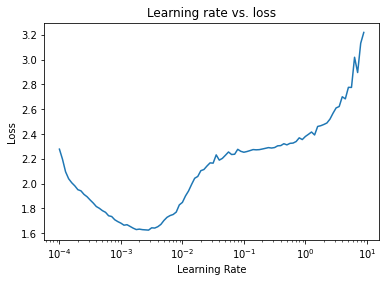

In [82]:
epoch = 100
lr = 1e-4 * (10**(np.arange(epoch)/20))
# plt.figure(figsize=(20,5))
plt.semilogx(lr, history3.history['loss'])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");
plt.show()

In [83]:
# Build Artificial Neural Network 

# set seed
tf.random.set_seed(42)

X_INPUT_SHAPE = 7
Y_INPUT_SHAPE = 10

# create ANN architecture
model4 = tf.keras.Sequential([
          
          #first layer + Dropout
          tf.keras.layers.Dense(50, input_shape=(X_INPUT_SHAPE,), activation='relu', name='First_layer'),
          tf.keras.layers.Dropout(0.2),

          # second layer + Dropout
          tf.keras.layers.Dense(100, activation='relu', name='second_layer'),
          tf.keras.layers.Dropout(0.2),

          # Third layer + Dropout
          tf.keras.layers.Dense(150, activation='relu', name='third_layer'),
          tf.keras.layers.Dropout(0.2),

          # # fourth layer
          # tf.keras.layers.Dense(100, activation='relu', name='fourth_layer'),
          # tf.keras.layers.Dropout(0.2),

          # output layer - one hot y_values
          tf.keras.layers.Dense(Y_INPUT_SHAPE, activation='softmax', name='output_layer')
])

# compile model
model4.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.0008),
    metrics=['accuracy']
)

history4 = model4.fit(X_train, y_train, epochs=50,
                      validation_data=(X_val,y_val),
                      verbose=1)

Epoch 1/50
197/197 [==============================] - 1s 4ms/step - loss: 2.1792 - accuracy: 0.1756 - val_loss: 2.0552 - val_accuracy: 0.2175
Epoch 2/50
197/197 [==============================] - 1s 3ms/step - loss: 2.0249 - accuracy: 0.2385 - val_loss: 1.9543 - val_accuracy: 0.2561
Epoch 3/50
197/197 [==============================] - 1s 3ms/step - loss: 1.9635 - accuracy: 0.2661 - val_loss: 1.8974 - val_accuracy: 0.2647
Epoch 4/50
197/197 [==============================] - 1s 3ms/step - loss: 1.9323 - accuracy: 0.2747 - val_loss: 1.8657 - val_accuracy: 0.3019
Epoch 5/50
197/197 [==============================] - 1s 3ms/step - loss: 1.8954 - accuracy: 0.2916 - val_loss: 1.8256 - val_accuracy: 0.3448
Epoch 6/50
197/197 [==============================] - 1s 3ms/step - loss: 1.8643 - accuracy: 0.3080 - val_loss: 1.7940 - val_accuracy: 0.3433
Epoch 7/50
197/197 [==============================] - 1s 3ms/step - loss: 1.8326 - accuracy: 0.3245 - val_loss: 1.7675 - val_accuracy: 0.3763
Epoch 

<Figure size 720x720 with 0 Axes>

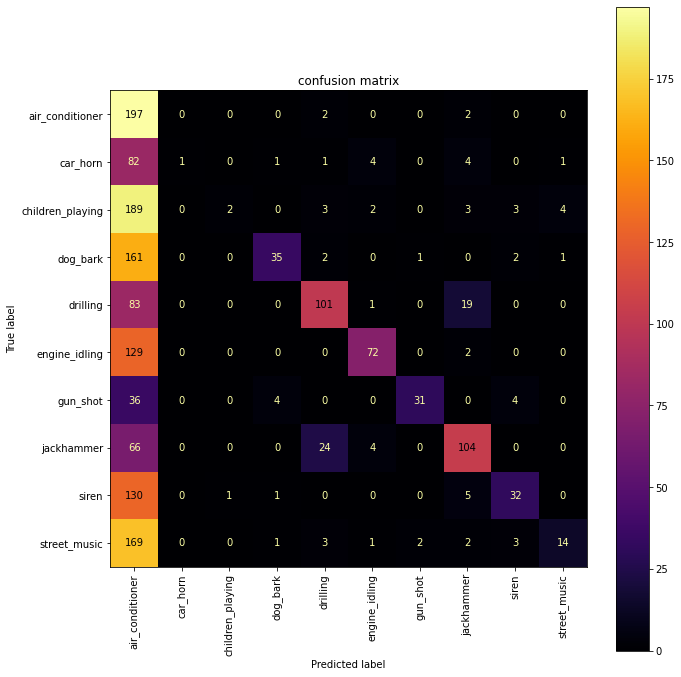

In [84]:
# confusion metrics

# make prediction
y_pred = tf.round(model4.predict(X_test))


# create confusion metrics
metric = cm(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))

labels = ['air_conditioner','car_horn','children_playing','dog_bark',
          'drilling','engine_idling','gun_shot','jackhammer','siren',
          'street_music']

plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(metric, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='inferno')
plt.title('confusion matrix')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [85]:
# encode y labels
le = LabelEncoder()
y_values = df.labels
# print(y_values)

y_encode = le.fit_transform(y_values)
print(y_encode)
mappings = {index: label for index, label in enumerate(le.classes_)}
print('encoded data mapping')
print(mappings)
print('\n \n')

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_encode, test_size=0.2,
                                                    random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

[1 1 1 ... 4 4 4]
encoded data mapping
{0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}

 



((6985, 7), (1747, 7), (6985,), (1747,))

In [86]:
# try out ml algorithms

models = { 'kNN' : KNeighborsClassifier(),
           'SVC' : SVC(C=1.0,kernel='rbf'),
           'DecisionTreeClassifier' : DecisionTreeClassifier(),
           'RandomForestClassifier' : RandomForestClassifier(),
           'LogisticRegression'  : LogisticRegression(),
           'GaussianNB' :  GaussianNB(),
           'MLPClassifier' : MLPClassifier(hidden_layer_sizes=(128,128)),
}

for name, model in models.items():
   model.fit(X_train,y_train)

   #Predictiing on Test Set
   y_pred = model.predict(X_test)

   #Evaluating model using f1_score
   print(f'{name} Accuracy score on test set is : {accuracy_score(y_test,y_pred)}') 
   print('\n')



kNN Accuracy score on test set is : 0.6416714367487121


SVC Accuracy score on test set is : 0.4636519748139668


DecisionTreeClassifier Accuracy score on test set is : 0.5792787635947338


RandomForestClassifier Accuracy score on test set is : 0.6794504865483686


LogisticRegression Accuracy score on test set is : 0.3686319404693761


GaussianNB Accuracy score on test set is : 0.3102461362335432


MLPClassifier Accuracy score on test set is : 0.522610188895249


